# Setup environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/'Colab Notebooks'/

/content/drive/MyDrive/Colab Notebooks


In [3]:
from utility import getComments, getReviewFinal

In [4]:
%cd Thesis/PeerRead/code/accept_classify/

/content/drive/My Drive/Colab Notebooks/Thesis/PeerRead/code/accept_classify


# Import library and Load Data


In [5]:
path = '../../my_data/Figures/02-Score-Acceptance-'

In [6]:
import json, pickle, os
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, plot_roc_curve

sns.set_context("talk", font_scale=2)

In [7]:
r_test_path = "../../data/iclr_2017/test/reviews/"
test_files  = list(map(lambda f: r_test_path+f, os.listdir(r_test_path)))

test_target = []
for name in tqdm(test_files):
   if getComments(name):
     test_target.append(getReviewFinal(name))     

  0%|          | 0/38 [00:00<?, ?it/s]

# BERT

In [8]:
with open('../../my_data/02-Review-Acceptance/bert_outcome-16', "rb") as f:
    outcome_bert=pickle.load(f) 
df_bert=pd.DataFrame(outcome_bert)

In [9]:
df_bert['avg'] = df_bert.apply(lambda row: (row['roc_auc']+row['accuracy'])/2, axis=1)


In [10]:
df_bert.sort_values('avg',ascending=False).head(5)

,roc_auc,accuracy,probs,fpr,tpr,avg
4,0.649275,0.684211,"[[0.7403236, 0.25967643], [0.61115927, 0.38884...","[0.0, 0.0, 0.0, 0.08695652173913043, 0.0869565...","[0.0, 0.06666666666666667, 0.2, 0.2, 0.2666666...",0.666743
3,0.582609,0.657895,"[[0.92592865, 0.074071325], [0.900069, 0.09993...","[0.0, 0.043478260869565216, 0.0434782608695652...","[0.0, 0.0, 0.26666666666666666, 0.266666666666...",0.620252
9,0.628986,0.605263,"[[0.6170595, 0.3829405], [0.62026876, 0.379731...","[0.0, 0.043478260869565216, 0.0869565217391304...","[0.0, 0.0, 0.0, 0.26666666666666666, 0.2666666...",0.617124
1,0.626087,0.605263,"[[0.95649487, 0.0435052], [0.8960344, 0.103965...","[0.0, 0.0, 0.0, 0.13043478260869565, 0.1304347...","[0.0, 0.06666666666666667, 0.2, 0.2, 0.2666666...",0.615675
0,0.591304,0.631579,"[[0.9082663, 0.09173366], [0.91442376, 0.08557...","[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.611442


In [11]:
PROBS_b = np.array([out['probs'] for out in outcome_bert])
ACC_b   = np.array([out['accuracy'] for out in outcome_bert])
FPR_b   = np.array([out['fpr'] for out in outcome_bert])
TPR_b   = np.array([out['tpr'] for out in outcome_bert])
AUC_b   = np.array([out['roc_auc'] for out in outcome_bert])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [12]:
cf_matrix_b = confusion_matrix(test_target, PROBS_b[4].argmax(axis=1))
print(cf_matrix_b)

[[18  5]
 [ 7  8]]


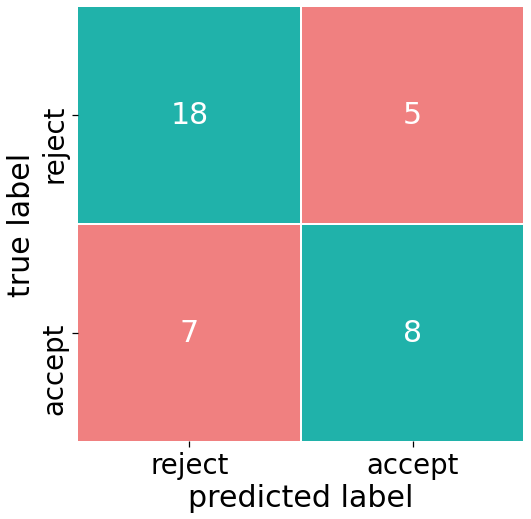

In [17]:
from matplotlib import colors
sns.set_context("notebook", font_scale=2.5)
fig,ax = plt.subplots(figsize = (8,8))
cmap = colors.ListedColormap(['lightcoral','lightseagreen','lightcoral','lightseagreen'])
bounds=[0, 5.5, 6.5, 7.5, 12]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(cf_matrix_b, annot=True, 
           cmap=cmap, norm=norm, linewidths=.5,  cbar=False)


plt.xlabel("predicted label") 
plt.ylabel("true label")
plt.xticks([0.5, 1.5], ['reject', 'accept'])  
plt.yticks([0.5, 1.5], ['reject', 'accept']) 
plt.savefig(path+'bert_confusion-matrix',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )


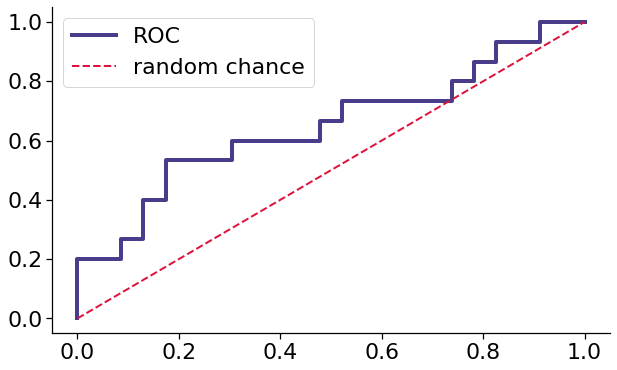

In [51]:
sns.set_context("notebook", font_scale=2)
fig,ax=plt.subplots(figsize = (10,6))

ax.plot(FPR_b[4], TPR_b[4],label='ROC', color='darkslateblue', lw=4)
ax.plot([0, 1], [0, 1],label='random chance', color='crimson', lw=2, linestyle='dashed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.savefig(path+'bert_ROC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [20]:
from sklearn.metrics import classification_report
target_names = ['Reject', 'Accept']
print(classification_report(test_target, PROBS_b[4].argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Reject       0.72      0.78      0.75        23
      Accept       0.62      0.53      0.57        15

    accuracy                           0.68        38
   macro avg       0.67      0.66      0.66        38
weighted avg       0.68      0.68      0.68        38



In [21]:
df_bert.describe()

,roc_auc,accuracy,avg
count,10.000000,10.000000,10.000000
mean,0.580000,0.602632,0.591316
std,0.065863,0.050314,0.052255
min,0.431884,0.526316,0.479100
25%,0.571014,0.559211,0.579662
50%,0.586957,0.605263,0.606369
75%,0.628261,0.631579,0.616762
max,0.649275,0.684211,0.666743


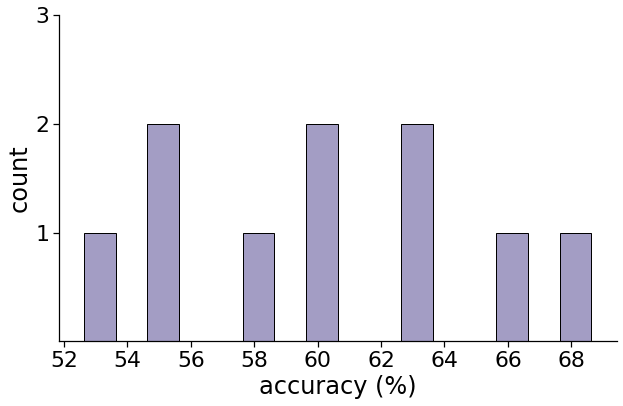

In [28]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(x=ACC_b, alpha=0.5, color= 'darkslateblue', ax=ax, binwidth=0.01)
sns.despine()
plt.ylabel('count')
plt.xlabel('accuracy (%)')
ax.set_yticks([1,2,3])
ax.set_xticks([0.52, 0.54, 0.56, 0.58,0.60, 0.62, 0.64, 0.66, 0.68])
ax.set_xticklabels(['52','54','56','58','60', '62', '64', '66', '68'])
plt.savefig(path+'bert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

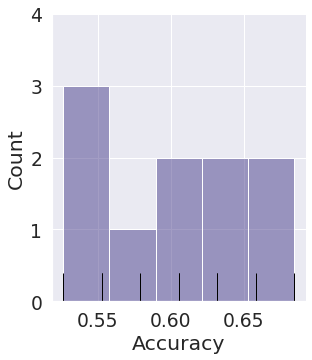

In [ ]:
sns.displot(x=ACC_b, alpha=0.5, color= 'darkslateblue')
sns.rugplot(x=ACC_b, height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.ylim(0,4)
plt.savefig(path+'bert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

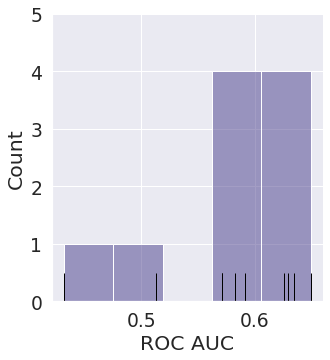

In [ ]:
sns.displot(x=AUC_b, alpha=0.5, color='darkslateblue')
sns.rugplot(x=AUC_b, height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('ROC AUC')
plt.savefig(path+'bert_AUC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

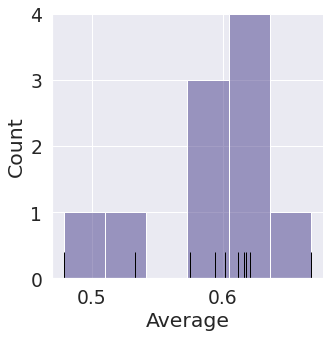

In [ ]:
sns.displot(data=df_bert, x='avg', alpha=0.5, color='darkslateblue')
sns.rugplot(data=df_bert, x='avg',  height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Average')
plt.ylim(0,4)
plt.savefig(path+'bert_Avg',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [30]:
data=PROBS_b[4]
outcome=np.argmax(data,axis=1)
probs = [data[i,outcome[i]] for i in range(len(data))]
outcome_str = list(map(lambda x: 'accept' if x==1 else 'reject', outcome))

In [31]:
df_ar = pd.DataFrame(np.vstack((probs,outcome_str)).T,columns=['probs','outcome'])

df_ar["probs"] = pd.to_numeric(df_ar["probs"])

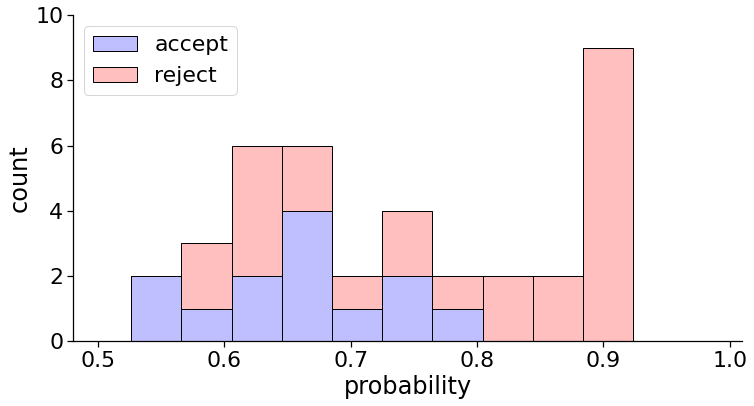

In [34]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=df_ar, x='probs', hue='outcome', multiple='stack', palette='bwr_r', bins=10,  ax=ax)
sns.despine()
plt.ylabel('count')
plt.xlabel('probability')
plt.legend(['accept', 'reject'])
plt.xlim(0.48, 1.01)
plt.ylim(0,10)
plt.savefig(path+'bert_prob',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

# SciBert

In [35]:
with open('../../my_data/02-Review-Acceptance/scibert_outcome-16', "rb") as f:
    outcome_scibert=pickle.load(f) 
df_scibert=pd.DataFrame(outcome_scibert)

In [36]:
df_scibert['avg'] = df_scibert.apply(lambda row: (row['roc_auc']+row['accuracy'])/2, axis=1)

In [37]:
df_scibert.sort_values('avg',ascending=False).head(5)

,roc_auc,accuracy,probs,fpr,tpr,avg
8,0.631884,0.657895,"[[0.9241922, 0.07580774], [0.38548, 0.6145201]...","[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.644889
3,0.678261,0.526316,"[[0.93684316, 0.06315681], [0.92472696, 0.0752...","[0.0, 0.0, 0.0, 0.30434782608695654, 0.3043478...","[0.0, 0.06666666666666667, 0.2, 0.2, 0.4, 0.4,...",0.602288
1,0.513043,0.605263,"[[0.89160657, 0.10839349], [0.6592108, 0.34078...","[0.0, 0.0, 0.21739130434782608, 0.217391304347...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.559153
9,0.556522,0.526316,"[[0.9421933, 0.0578067], [0.9018734, 0.0981266...","[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.541419
0,0.501449,0.578947,"[[0.971916, 0.028084002], [0.9727045, 0.027295...","[0.0, 0.0, 0.0, 0.21739130434782608, 0.2173913...","[0.0, 0.06666666666666667, 0.2, 0.2, 0.2666666...",0.540198


In [38]:
PROBS_s = np.array([out['probs'] for out in outcome_scibert])
ACC_s   = np.array([out['accuracy'] for out in outcome_scibert])
FPR_s   = np.array([out['fpr'] for out in outcome_scibert])
TPR_s   = np.array([out['tpr'] for out in outcome_scibert])
AUC_s   = np.array([out['roc_auc'] for out in outcome_scibert])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [39]:
cf_matrix = confusion_matrix(test_target, PROBS_s[8].argmax(axis=1))
print(cf_matrix)

[[19  4]
 [ 9  6]]


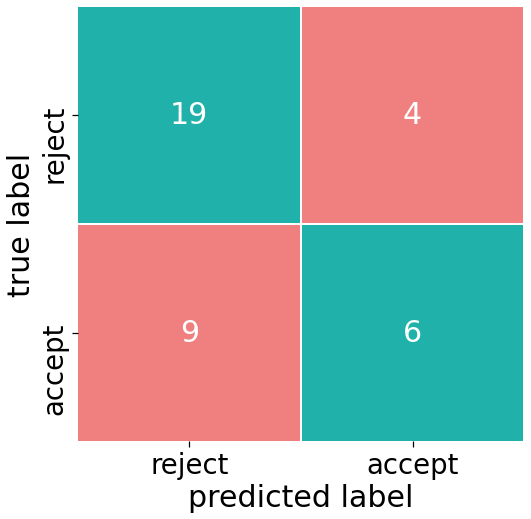

In [44]:
from matplotlib import colors
sns.set_context("notebook", font_scale=2.5)
fig,ax = plt.subplots(figsize = (8,8))
cmap = colors.ListedColormap(['lightcoral','lightseagreen','lightcoral','lightseagreen'])
bounds=[0, 5, 7, 10, 12]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(cf_matrix, annot=True, 
           cmap=cmap, norm=norm, linewidths=.5,  cbar=False)


plt.xlabel("predicted label") 
plt.ylabel("true label")
plt.xticks([0.5, 1.5], ['reject', 'accept'])  
plt.yticks([0.5, 1.5], ['reject', 'accept']) 
plt.savefig(path+'scibert_confusion-matrix',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )


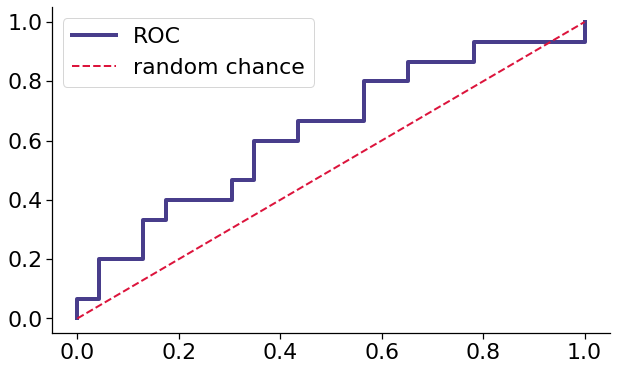

In [50]:
sns.set_context("notebook", font_scale=2)
fig,ax=plt.subplots(figsize = (10,6))

ax.plot(FPR_s[8], TPR_s[8],label='ROC', color='darkslateblue', lw=4)
ax.plot([0, 1], [0, 1],label='random chance', color='crimson', lw=2, linestyle='dashed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.savefig(path+'scibert_ROC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [48]:
from sklearn.metrics import classification_report
target_names = ['Reject', 'Accept']
print(classification_report(test_target, PROBS_s[8].argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Reject       0.68      0.83      0.75        23
      Accept       0.60      0.40      0.48        15

    accuracy                           0.66        38
   macro avg       0.64      0.61      0.61        38
weighted avg       0.65      0.66      0.64        38



In [49]:
df_scibert.describe()

,roc_auc,accuracy,avg
count,10.000000,10.000000,10.000000
mean,0.527826,0.539474,0.533650
std,0.078961,0.065936,0.059798
min,0.417391,0.447368,0.449771
25%,0.489130,0.506579,0.502059
50%,0.507246,0.539474,0.532170
75%,0.553623,0.572368,0.554720
max,0.678261,0.657895,0.644889


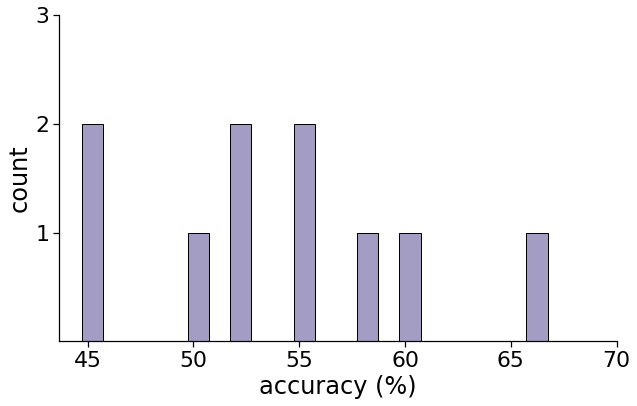

In [58]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(x=ACC_s, alpha=0.5, color= 'darkslateblue', ax=ax, binwidth=0.01)
sns.despine()
plt.ylabel('count')
plt.xlabel('accuracy (%)')
ax.set_yticks([1,2,3])
ax.set_xticks([0.45, 0.50, 0.55, 0.60, 0.65, 0.70])
ax.set_xticklabels(['45','50','55','60', '65', '70'])
plt.savefig(path+'scibert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

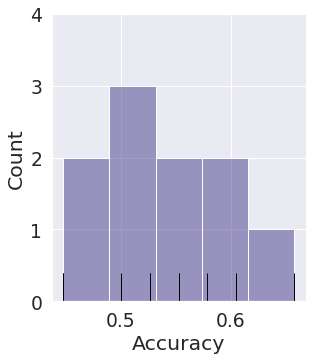

In [ ]:
sns.displot(x=ACC_s, alpha=0.5, color= 'darkslateblue')
sns.rugplot(x=ACC_s, height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.ylim(0,4)
plt.savefig(path+'scibert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0)

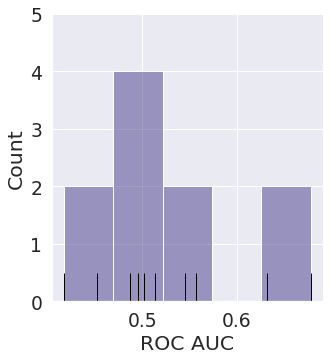

In [ ]:
sns.displot(x=AUC_s, alpha=0.5, color='darkslateblue')
sns.rugplot(x=AUC_s, height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('ROC AUC')
plt.savefig(path+'scibert_AUC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

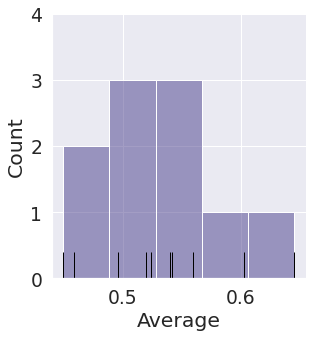

In [ ]:
sns.displot(data=df_scibert, x='avg', alpha=0.5, color='darkslateblue')
sns.rugplot(data=df_scibert, x='avg',  height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Average')
plt.ylim(0,4)
plt.savefig(path+'scibert_Avg',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [59]:
data=PROBS_s[8]
outcome=np.argmax(data,axis=1)
probs = [data[i,outcome[i]] for i in range(len(data))]
outcome_str = list(map(lambda x: 'accept' if x==1 else 'reject', outcome))

In [60]:
df_ar = pd.DataFrame(np.vstack((probs,outcome_str)).T,columns=['probs','outcome'])

df_ar["probs"] = pd.to_numeric(df_ar["probs"])

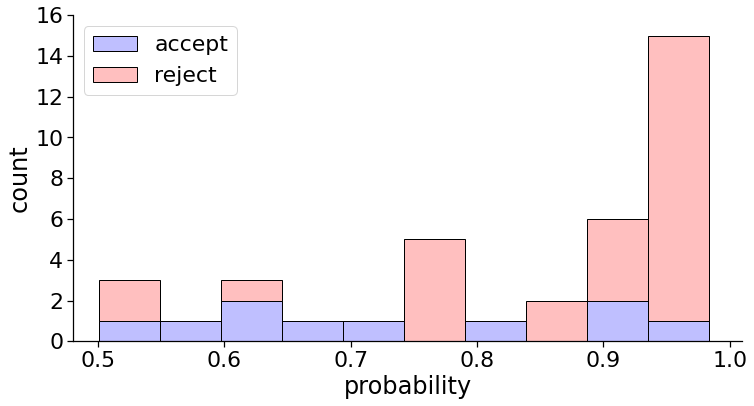

In [67]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=df_ar, x='probs', hue='outcome', multiple='stack', palette='bwr_r', bins=10,  ax=ax)
sns.despine()
plt.ylabel('count')
plt.xlabel('probability')
plt.legend(['accept', 'reject'])
plt.xlim(0.48, 1.01)
plt.ylim(0,16)
ax.set_yticks([0,2,4,6,8,10,12,14,16])
plt.savefig(path+'scibert_prob',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )